In [1]:
import konlpy.tag
import pandas as pd 
from pandas import DataFrame as df
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
import re 

# Training Dataset 만들기  

In [2]:
#데이터 확인 (Training Set) , reviews2(통합) 은 5만개의 16년도이전 네이버 맛집 리뷰 데이터
dataset = pd.read_csv("reviews2(통합).csv",encoding = "cp949")

In [3]:
#null 데이터 있는지 확인
print(dataset['comments'].isnull().values.any())

False


In [57]:
#Label 정리 --> 4,5점이면 긍정(1), 1,2,3점이면 부정(0) 
i=0
train_label = []
for i in range(50000):
    if dataset["score"][i] >3.0:
        train_label.append(1)
    else:
        train_label.append(0)
f = open('label_train.txt' , 'w', newline='', encoding = 'utf-8')
n = 0
for label in train_label :
    f.write(str(label)+'\n')
    n+=1
print(n)
f.close()
print(train_label[0:10])

50000
[1, 0, 1, 0, 0, 0, 0, 1, 1, 1]


# Test Dataset 만들기  

In [146]:
#Test Set로 홍대, 신촌, 강남 사용 
#현재 수집되어 있는 데이터 파일은 new 이름이 붙어있음
#새로 데이터를 수집한다면 파일이름에 유의
dataset_hongdae = pd.read_csv("result_review(홍대new).csv",encoding = "utf-8")
dataset_sinchon = pd.read_csv("result_review(신촌new).csv",encoding = "utf-8")
dataset_gangnam = pd.read_csv("result_review(강남new).csv",encoding = "utf-8")

In [147]:
#null 데이터 있는지 확인
print(dataset_hongdae['리뷰'].isnull().values.any())
print(dataset_sinchon['리뷰'].isnull().values.any())
print(dataset_gangnam['리뷰'].isnull().values.any())

True
True
True


In [148]:
# null 데이터가 있다면 삭제해준다 
dataset_hongdae=dataset_hongdae.dropna(axis = 0) # null 데이터 삭제
print(dataset_hongdae.isnull().values.any()) # 삭제가 잘 되었는지 확인

dataset_sinchon=dataset_sinchon.dropna(axis = 0) # null 데이터 삭제
print(dataset_sinchon.isnull().values.any()) # 삭제가 잘 되었는지 확인

dataset_gangnam=dataset_gangnam.dropna(axis = 0) # null 데이터 삭제
print(dataset_gangnam.isnull().values.any()) # 삭제가 잘 되었는지 확인

False
False
False


In [149]:
#null 제외한 리뷰 데이터 숫자 파악
print(len(dataset_sinchon['리뷰']))
print(len(dataset_sinchon['평점']))
print(len(dataset_hongdae['리뷰']))
print(len(dataset_hongdae['평점']))
print(len(dataset_gangnam['리뷰']))
print(len(dataset_gangnam['평점']))

8044
8044
13740
13740
25519
25519


In [150]:
#홍대 Label 정리 --> 4,5점이면 긍정(1), 1,2,3점이면 부정(0) 
i=0
test_label_h = []
for stars in dataset_hongdae['평점']:
    if stars >3.0:
        test_label_h.append(1)
    else:
        test_label_h.append(0)
f = open('label_h.txt' , 'w', newline='')
n = 0
for label in test_label_h :
    f.write(str(label)+'\n')
    n+=1
print(n)
f.close()
print(test_label_h[0:5])
print(len(test_label_h))

13740
[1, 0, 0, 1, 1]
13740


In [151]:
#신촌 Label 정리 --> 4,5점이면 긍정(1), 1,2,3점이면 부정(0) 
i=0
test_label_s = []
for stars in dataset_sinchon['평점']:
    if stars >3.0:
        test_label_s.append(1)
    else:
        test_label_s.append(0)
f = open('label_s.txt' , 'w', newline='')
n = 0
for label in test_label_s :
    f.write(str(label)+'\n')
    n+=1
print(n)
f.close()
print(test_label_s[0:5])
print(len(test_label_s))

8044
[1, 1, 1, 1, 1]
8044


In [152]:
#강남 Label 정리 --> 4,5점이면 긍정(1), 1,2,3점이면 부정(0) 
i=0
test_label_g = []
for stars in dataset_gangnam['평점']:
    if stars >3.0:
        test_label_g.append(1)
    else:
        test_label_g.append(0)
f = open('label_g.txt' , 'w', newline='')
n = 0
for label in test_label_g :
    f.write(str(label)+'\n')
    n+=1
print(n)
f.close()
print(test_label_g[0:5])
print(len(test_label_g))

25519
[0, 1, 1, 1, 1]
25519


# 불용어 사전 정리

In [68]:
def filter(s): 
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub("",s)
    return result 

In [69]:
#한글과 공백말고 모두 제거 , 불용어사전 정리 

train_data = list(dataset['comments'])
test_hongdae = list(dataset_hongdae['리뷰'])
test_sinchon = list(dataset_sinchon['리뷰'])
test_gangnam = list(dataset_gangnam['리뷰'])

for i in range(len(train_data)):
    train_data[i] = filter(train_data[i]) 
    
for i in range(len(test_hongdae)):
    test_hongdae[i] = filter(test_hongdae[i])

for i in range(len(test_sinchon)):
     test_sinchon[i] = filter(test_sinchon[i])
for i in range(len(test_gangnam)):
     test_gangnam[i] = filter(test_gangnam[i])


In [15]:
from kornounextractor.noun_extractor import extract
# 새로운 명사 등록 필요


tmp1 = ''
for line in test_hongdae :
    tmp1 = tmp1 + line+ ' '

tmp2 = ''
for line in test_sinchon :
    tmp2 = tmp2 + line + ' '
tmp3 = ''
for line in test_gangnam :
    tmp3 = tmp3 + line + ' '

In [16]:
#문서에서 2번이상 나온 단어를 추출 , 데이터가 많아 시간이 다소 걸림. 그래서 매번 하기 힘들어 뒤에 텍스트 파일에 따로 저장.
nouns1 = sorted(extract(tmp1 ,freq=2))
nouns2 = sorted(extract(tmp2 ,freq=2))
nouns3 = sorted(extract(tmp3, freq=2))

add_noun2 = nouns1 + nouns2 + nouns3

In [73]:
stopwords = open("한국어불용어100.txt",'r',encoding="utf-8")
foods = open("food_name.txt",'r',encoding="utf-8")
stopwords2 = open("stop_word.txt", 'r')
stop = []
for lines in stopwords: 
    stop.append(lines.split("\t")[0])
for lines in stopwords2 :
    stop.append(lines.split("\n")[0])
food_list = []
#food list 는 음식이름들
for word in foods:
    food_list.append(word.split("\n")[0])
stop = stop + food_list
stopword= list(set(stop))
print(len(stopword))
print(stopword)

622
['하', '잼', '갈치', '냉면', '조식', '보르시', '다만', '생각하', '생선회', '자몽에이드', '티본스테이크', '찰밥', '기름사탕', '뭔가', '만두기', '그렇', '단맛감', '쉐이크 ', '갈비살목살오겹살', '막국수', '사이다', '아웃백', '건', '컵라면', '강정', '빵', '건빵', '케이크', '보신탕', '단디', '감자', '샴팡', '절하', '어요', '명', '규돈', '제', '보이', '수산물', '닭고기덮밥', '식혜', '단얼음', '쌀떡', '주시', '월', '삼계탕', '하진', '젖가공품', '압생트', '딸기케이크', '골동반', '묵', '집', '국수발', '년', '밀가루', '채소', '족발', '애', '으로', '된장', '차', '고추가루', '와사비', '맥주', '고로케', '코코아', '막대사탕', '송화다식', '면발', '점', '해물', '대창', '샤브', '갈매기살', '얼음보숭이', '시키', '잘', '소갈비', '문어', '장어덮밥', '카레', '엿', '날치알', '고기', '셔벗', '소만두', '샐러드파스타', '어가', '썩장', '두부', '아니', '양념 ', '고량주', '비빔밥', '밀국수', '소젖', '소주', '닭꼬치', '데', '보쌈', '인절미', '속', '함', '양갱', '이나', '뜨더국', '튀기', '숯불 ', '하지', '셔', '얼럭밥', '올리브유', '계란덮밥', '스파게티', '그런', '라바슈', '간장게장', '마카로니', '요', '콜라', '케첩', '원', '브런치', '알탕', '머스터드소스', '박하사탕', '떡꼬치', '볶음', '달걀말이', '경우', '레몬수', '까까', '소스', '부침개', '회덮밥', '케익', '중', '갈비살목살', '\ufeff이', '스시', '플로프', '크림', '오미자차', '짬뽕', '버터', '딸기케익', '칼국', '국숫발', '사람', '아주'

In [74]:
from ckonlpy.tag import Twitter
from ckonlpy.tag import Postprocessor
twitter = Twitter()

# 우리가 구한 새로운 명사들을 twitter 사전에 추가
for word in add_noun2 :
    twitter.add_dictionary(word , 'Noun')
#우리에게 필요한 의미있는 품사들만 선택    
meaningful = ["Adjective","Adverb","Noun"]

postprocessor = Postprocessor(twitter, stopwords = stopword, passtags = meaningful)

C:\workspace\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


[('오크', 'Noun'), ('로시', 'Noun'), ('카', 'Noun'), ('가성비', 'Noun'), ('이쁘다', 'Adjective')]


In [72]:
# 위에서 구한 새로운 단어들을 텍스트 파일로 저장.
f = open('add_noun_2.txt', 'w', newline = '')
for word in add_noun2 :
    f.write(word+' ')
f.close

<function TextIOWrapper.close()>

# 전처리 - 불용어 제거 및 형태소(adj, noun, adverb 만 뽑기 ) 정리 

In [76]:
# train dataset 처리


comments_pos = []
for lines in train_data:
    tmp = postprocessor.pos(lines)
    comments_pos.append(tmp)

In [77]:
# 홍대test dataset 처리

comments_pos_h = []
for lines in test_hongdae :
    tmp = postprocessor.pos(lines)
    comments_pos_h.append(tmp)

In [78]:
# 강남test dataset 처리

comments_pos_g = []
for lines in test_gangnam:
    tmp = postprocessor.pos(lines)
    comments_pos_g.append(tmp)

In [79]:
#신촌 test dataset 처리

comments_pos_s = []
for lines in test_sinchon:
    tmp = postprocessor.pos(lines)
    comments_pos_s.append(tmp)

In [145]:
#품사별로 정리한 단어를 string 형태로 변환 -> training에서 사용

train_string = [] # Train
tmp = ""
for lines in comments_pos: 
    tmp = ""
    i=0
    for words in lines:
        if i==0:
            tmp = words[0]
        else: 
            tmp = tmp + " " + words[0]
        i+=1
    train_string.append(tmp)

test_string_h = [] #Test_홍대
tmp1 = ""
for lines in comments_pos_h: 
    tmp1 = ""
    i=0
    for words in lines: 
        if i==0:
            tmp1 = words[0]
        else: 
            tmp1 = tmp1 + " " + words[0]
        i+=1
    test_string_h.append(tmp1)

test_string_s = [] #Test_신촌
tmp2 = ""
for lines in comments_pos_s: 
    tmp2 = ""
    i=0
    for words in lines: 
        if i==0:
            tmp2 = words[0]
        else: 
            tmp2 = tmp2 + " " + words[0]
        i+=1
    test_string_s.append(tmp2)
    
test_string_g = [] #Test_강남
tmp3 = ""
for lines in comments_pos_g: 
    tmp3 = ""
    i=0
    for words in lines: 
        if i==0:
            tmp3 = words[0]
        else: 
            tmp3 = tmp3 + " " + words[0]
        i+=1
    test_string_g.append(tmp3)
print(len(test_string_g))

25519


In [81]:
# 형태소별로 정리한 단어를 리스트로 정리 -> training에서 사용
train_list = []
tmp = []
for i in range(len(train_data)): 
    tmp = []
    for words in comments_pos[i]: 
        tmp.append(words[0])
    train_list.append(tmp)

test_list_h = []
tmp1 = []
for i in range(len(test_hongdae)): 
    tmp1 = []
    for words in comments_pos_h[i]: 
        tmp1.append(words[0])
    test_list_h.append(tmp1)

test_list_s = []
tmp2 = []
for i in range(len(test_sinchon)): 
    tmp2 = []
    for words in comments_pos_s[i]: 
        tmp2.append(words[0])
    test_list_s.append(tmp2)
    
test_list_g = []
tmp3 = []
for i in range(len(test_gangnam)): 
    tmp3 = []
    for words in comments_pos_g[i]: 
        tmp3.append(words[0])
    test_list_g.append(tmp3)

In [82]:
print(train_string[0:5])
print(len(test_string_s))
print(test_list_s[0:5])
print(test_list_g[0:5])

['오늘 오니기리 이규동 규동 진짜 합리 가격 호강 막 풍선 주인 바 맛 한번 고 주인 바 그런지 맛있어졌', '여기 미스터 파파 임실 그렇습니다 낚였네 가격 저렴 만큼 토핑 부 실하', '숯불 맛 처음 진짜 맛있었 춘천 가보 정말 강추', '바하 커피샵 체적 분위기 작고 부담 없다고 커피맛 좋은집 카페인 적으 달콤한 향 종류 많아서 재미 쏠쏠하다', '페북 가관 장사 망']
8044
[['맛나', '매콤', '매운거', '친구', '맛있게', '등갈비', '함께', '이것', '존맛', '입니다', '등갈비', '짱'], ['김치구이', '완전', '배터', '지게', '인기', '아보', '다음', '가야'], ['매운거', '스트레스', '확', '오랜만', '맛있게', '다음'], ['런치', '타임', '있어', '좋음'], ['완전', '대박', '옆', '테이블', '양푼', '맛있어', '여서', '다음', '올땐', '그거', '먹기']]
[['점심시간', '손님', '서인', '서빙', '라주시', '피곤', '신지', '표정', '거의', '없음', '지난번', '회사', '회식때', '좋은', '기억', '예약', '거래처', '모시', '여기', '서비스', '왜', '며', '한마디'], ['굿굿'], ['돼지갈비', '오겹살', '맛있었'], ['맛있었고', '양', '곰탕', '냄새', '심함', '비츄'], ['서비스', '조아']]


In [83]:
# 저장 
f = open("train_string.txt",'w',encoding = 'utf-8')
for lines in train_string:
    f.write(lines+"\n")

f = open("test_string_h.txt",'w',encoding = 'utf-8')
for lines in test_string_h:
    f.write(lines+"\n")
    
f = open("test_string_s.txt",'w',encoding = 'utf-8')
for lines in test_string_s:
    f.write(lines+"\n")
f = open("test_string_g.txt",'w',encoding = 'utf-8')
for lines in test_string_g:
    f.write(lines+"\n")

# 빈도수 분석  

In [84]:
#noun만 추출 

i=0
meaningful = ["Noun"]
nouns_train = [] #데이터셋  
nouns_h = [] #홍대 테스트셋
nouns_s = [] #신촌 테스트셋
nouns_g = [] #강남 테스트셋

for i in range(len(train_data[:20000])):
    tmp = []
    for word in comments_pos[i]:
        if word[1] in meaningful: 
            tmp.append(word)
    nouns_train.append(tmp)

for i in range(len(test_sinchon)):
    tmp1 = []
    for word in comments_pos_s[i]:
        if word[1] in meaningful: 
            tmp1.append(word)
    nouns_s.append(tmp1)

for i in range(len(test_hongdae)):
    tmp2 = []
    for word in comments_pos_h[i]:
        if word[1] in meaningful: 
            tmp2.append(word)
    nouns_h.append(tmp2)
    
for i in range(len(test_gangnam)):
    tmp3 = []
    for word in comments_pos_g[i]:
        if word[1] in meaningful: 
            tmp3.append(word)
    nouns_g.append(tmp3)

In [85]:
# 빈 리스트 삭제
i=0
for word in nouns_train: 
    if len(word) ==0:
        del nouns_train[i]
    i+=1
print(nouns_train[0:5])

j=0
for word in nouns_h: 
    if len(word) ==0:
        del nouns_h[j]
    j+=1
print(nouns_h[0:5])

k=0
for word in nouns_s: 
    if len(word) ==0:
        del nouns_s[k]
    k+=1
print(nouns_s[0:5])
m = 0
for word in nouns_g: 
    if len(word) ==0:
        del nouns_g[m]
    m+=1
print(nouns_g[0:5])

[[('오늘', 'Noun'), ('오니기리', 'Noun'), ('이규동', 'Noun'), ('규동', 'Noun'), ('진짜', 'Noun'), ('합리', 'Noun'), ('가격', 'Noun'), ('호강', 'Noun'), ('막', 'Noun'), ('풍선', 'Noun'), ('주인', 'Noun'), ('바', 'Noun'), ('맛', 'Noun'), ('한번', 'Noun'), ('고', 'Noun'), ('주인', 'Noun'), ('바', 'Noun')], [('여기', 'Noun'), ('미스터', 'Noun'), ('파파', 'Noun'), ('임실', 'Noun'), ('낚였네', 'Noun'), ('가격', 'Noun'), ('저렴', 'Noun'), ('만큼', 'Noun'), ('토핑', 'Noun'), ('부', 'Noun'), ('실하', 'Noun')], [('숯불', 'Noun'), ('맛', 'Noun'), ('처음', 'Noun'), ('진짜', 'Noun'), ('춘천', 'Noun'), ('가보', 'Noun'), ('정말', 'Noun'), ('강추', 'Noun')], [('바하', 'Noun'), ('커피샵', 'Noun'), ('체적', 'Noun'), ('분위기', 'Noun'), ('작고', 'Noun'), ('부담', 'Noun'), ('커피맛', 'Noun'), ('좋은집', 'Noun'), ('카페인', 'Noun'), ('적으', 'Noun'), ('향', 'Noun'), ('종류', 'Noun'), ('재미', 'Noun')], [('페북', 'Noun'), ('가관', 'Noun'), ('장사', 'Noun'), ('망', 'Noun')]]
[[('예약', 'Noun'), ('음료', 'Noun'), ('서비스', 'Noun'), ('안주시', 'Noun'), ('우삼겹', 'Noun'), ('방법', 'Noun')], [('랫러', 'Noun')], [('그냥', 'Noun'), ('그

In [86]:
#명사중 빈도 수 높은 10000개 뽑기 
#nouns_train, nouns_h, nouns_s ,nouns_g

import nltk
from collections import Counter

words_train = []
for sentence in nouns_train:
    for pos in sentence:
        words_train.append(pos[0])

c = Counter(words_train)
common_words = c.most_common(10000)
print(common_words[0:100])

[('맛', 6075), ('정말', 3565), ('진짜', 2857), ('여기', 2814), ('친절', 2349), ('서비스', 1973), ('음식', 1871), ('배달', 1864), ('전화', 1677), ('완전', 1599), ('손님', 1505), ('고', 1489), ('장님', 1476), ('가격', 1464), ('사장', 1404), ('사', 1397), ('다가', 1336), ('기분', 1252), ('직원', 1243), ('그냥', 1233), ('주문', 1226), ('불친절', 1086), ('친절하시', 1013), ('하시', 1003), ('깔끔', 985), ('추천', 934), ('최고', 927), ('돈', 920), ('한번', 902), ('자주', 901), ('가게', 888), ('처음', 875), ('장사', 867), ('거', 838), ('분위기', 835), ('별로', 822), ('맛집', 811), ('식당', 776), ('반찬', 761), ('별', 749), ('왜', 747), ('맛나', 730), ('엄청', 671), ('최악', 652), ('맛없', 649), ('양', 606), ('주인', 605), ('꼭', 605), ('양도', 605), ('오늘', 568), ('닭', 565), ('다음', 555), ('같이', 553), ('에요', 538), ('기', 530), ('대박', 527), ('가족', 525), ('알바생', 520), ('마세요', 511), ('보니', 508), ('달라', 506), ('평가', 488), ('짱', 487), ('절대', 484), ('메뉴', 483), ('안하', 483), ('싸가지', 480), ('알바', 475), ('강추', 474), ('저렴', 464), ('직접', 461), ('려고', 456), ('부터', 456), ('집이', 453), ('지도', 441), ('길'

In [87]:
#홍대 5000개 데이터 뽑기 
#신촌 5000개 데이터 뽑기
#강남 5000개 데이터 뽑기

words_h = []
for sentence in nouns_h:
    for pos in sentence:
        words_h.append(pos[0])

c1 = Counter(words_h)
common_words_h = c1.most_common(5000)
print(common_words_h[0:100])

words_s = []
for sentence in nouns_s:
    for pos in sentence:
        words_s.append(pos[0])

c2 = Counter(words_s)
common_words_s = c2.most_common(5000)
print(common_words_s[0:100])

words_g = []
for sentence in nouns_g:
    for pos in sentence:
        words_g.append(pos[0])

c3 = Counter(words_g)
common_words_g = c3.most_common(5000)
print(common_words_g[0:100])

[('맛', 2862), ('음식', 2499), ('분위기', 2051), ('친절', 1870), ('예약', 1721), ('방문', 1455), ('서비스', 1443), ('직원', 1271), ('정말', 1080), ('만족', 1009), ('가격', 999), ('친절하시', 734), ('진짜', 676), ('다음', 646), ('최고', 627), ('자리', 619), ('주문', 596), ('테이블', 567), ('해주시', 514), ('기분', 507), ('추천', 487), ('미리', 486), ('고', 477), ('홍대점', 477), ('홍대', 475), ('적으', 464), ('할인', 460), ('조금', 436), ('조용', 435), ('별로', 434), ('에요', 419), ('왜', 410), ('습', 407), ('하이디라오', 395), ('메뉴', 385), ('불구', 383), ('식사', 380), ('새우완자', 366), ('항상', 362), ('모두', 357), ('처음', 346), ('식당', 340), ('감사합니', 336), ('가게', 334), ('재', 332), ('다양', 331), ('역시', 319), ('장님', 299), ('만족합니', 299), ('사', 296), ('그냥', 294), ('친구', 291), ('직접', 290), ('살짝', 287), ('가성비', 284), ('이용', 274), ('궁금', 265), ('깔끔', 259), ('엄청', 259), ('바', 259), ('종업원', 259), ('종류', 251), ('외국인', 249), ('양', 245), ('늘', 242), ('요리', 242), ('첫', 241), ('구들', 240), ('설명', 240), ('같이', 236), ('가야', 236), ('맛집', 234), ('이상', 231), ('저렴', 229), ('맛나', 224), ('가족'

In [144]:
# 저장
common = open("common_train.txt",'w')
for tup in common_words: 
    common.write(tup[0]+"\t"+str(tup[1])+"\n")

common1 = open("common_hongdae.txt",'w')
for tup in common_words_h: 
    common1.write(tup[0]+"\t"+str(tup[1])+"\n")

common2 = open("common_sinchon.txt",'w')
for tup in common_words_s: 
    common2.write(tup[0]+"\t"+str(tup[1])+"\n")
    
common3 = open("common_gangnam.txt",'w')
for tup in common_words_g: 
    common3.write(tup[0]+"\t"+str(tup[1])+"\n")
common.close()
common1.close()
common2.close()
common3.close()


# 빈도수 WordCloud로 보여주기  

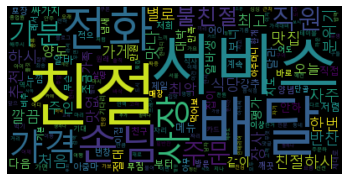

In [131]:
# WordCloud로 보여주기
noun_words = []
num = []
stop_noun = ['음식' , '진짜','여서', '에요', '마세요', '다가', '려고', '에요', '왜', '습', '정말', '진짜', '여기', '완전', '그냥', '예약',
             '고', '눈꽃피자', '항상', '새우완자', '오코노미야끼', '몬자', '피클', '사', '장님', '엄청', '일단']
for words1 in common_words:
    if words1[0] not in stop_noun:
        noun_words.append(words1[0])
        num.append(words1[1])

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from os import path

FONT_PATH = 'C:/Windows/Fonts/malgun.ttf' # For Korean characters

noun_text = ''
for word in noun_words:
    noun_text = noun_text +' '+word
    
wordcloud = WordCloud(max_font_size=80, relative_scaling=.5, font_path=FONT_PATH)
wordcloud.generate(noun_text) 
# generate() 는 하나의 string value를 입력 받음
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

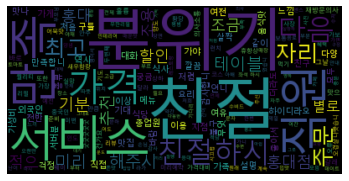

In [135]:
# 홍대 WordCloud로 보여주기
noun_words = []
num = []
stop_noun = ['음식' , '진짜','여서', '에요', '마세요', '다가', '려고', '에요', '왜', '습', '정말', '진짜', '여기', '완전', '그냥', '예약', '방문',
             '고', '눈꽃피자', '항상', '새우완자', '오코노미야끼', '몬자', '피클', '사', '장님', '엄청', '일단']
for words1 in common_words_h:
    if words1[0] not in stop_noun:
        noun_words.append(words1[0])
        num.append(words1[1])

FONT_PATH = 'C:/Windows/Fonts/malgun.ttf' # For Korean characters

noun_text = ''
for word in noun_words:
    noun_text = noun_text +' '+word
    
wordcloud = WordCloud(max_font_size=80, relative_scaling=.5, font_path=FONT_PATH)
wordcloud.generate(noun_text) 
# generate() 는 하나의 string value를 입력 받음
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

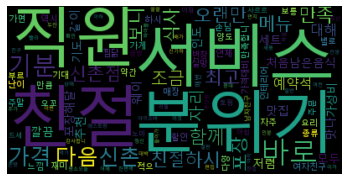

In [136]:
# 신촌 WordCloud로 보여주기
noun_words = []
num = []
stop_noun = ['음식' , '진짜','여서', '에요', '마세요', '다가', '려고', '에요', '왜', '습', '정말', '진짜', '여기', '완전', '그냥', '예약', '방문',
             '고', '눈꽃피자', '항상', '새우완자', '오코노미야끼', '몬자', '피클', '사', '장님', '엄청', '일단']
for words1 in common_words_s:
    if words1[0] not in stop_noun:
        noun_words.append(words1[0])
        num.append(words1[1])

FONT_PATH = 'C:/Windows/Fonts/malgun.ttf' # For Korean characters

noun_text = ''
for word in noun_words:
    noun_text = noun_text +' '+word
    
wordcloud = WordCloud(max_font_size=80, relative_scaling=.5, font_path=FONT_PATH)
wordcloud.generate(noun_text) 
# generate() 는 하나의 string value를 입력 받음
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

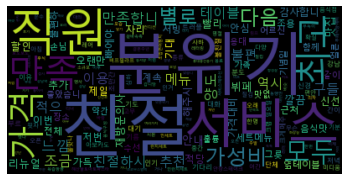

In [138]:
# 강남 WordCloud로 보여주기
noun_words = []
num = []
stop_noun = ['음식' , '진짜','여서', '에요', '마세요', '다가', '려고', '에요', '왜', '습', '정말', '진짜', '여기', '완전', '그냥', '예약', '방문', '식사', '감사',
             '고', '눈꽃피자', '항상', '새우완자', '오코노미야끼', '몬자', '피클', '사', '장님', '엄청', '일단']
for words1 in common_words_g:
    if words1[0] not in stop_noun:
        noun_words.append(words1[0])
        num.append(words1[1])

FONT_PATH = 'C:/Windows/Fonts/malgun.ttf' # For Korean characters

noun_text = ''
for word in noun_words:
    noun_text = noun_text +' '+word
    
wordcloud = WordCloud(max_font_size=80, relative_scaling=.5, font_path=FONT_PATH)
wordcloud.generate(noun_text) 
# generate() 는 하나의 string value를 입력 받음
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# LDA 토픽 모델링 

In [111]:
from gensim import corpora
from gensim import models
NUM_TOPICS = 10
NUM_TOPIC_WORDS = 10

In [112]:
from collections import defaultdict
def get_filtered_words(docs):
    term_fre_dict = defaultdict(int)
    doc_fre_dict = defaultdict(int)
    
    for doc in docs:
        for word in doc:
            term_fre_dict[word] += 1
        for word in set(doc):
            doc_fre_dict[word] += 1
    
    max_doc_frequency = 1000
    min_doc_frequency = 3
    max_term_frequency = 7000
    min_term_frequency = 5
    
    doc_frequency_filtered = {k:v for k, v in doc_fre_dict.items() if ((v>=min_doc_frequency) and (v <= max_doc_frequency))}
    term_frequency_filtered = {k:v for k, v in term_fre_dict.items() if ((v>=min_term_frequency) and (v <= max_term_frequency))}
    both_satisfied = {k:v for k, v in term_frequency_filtered.items() if k in doc_frequency_filtered}
    
    return both_satisfied

In [113]:
def get_highest_topic(topic_list):
    highest_topic = 100
    highest_prob = 0
    for topic, prob in topic_list:
        if prob > highest_prob:
            highest_prob = prob
            highest_topic = topic
    return highest_topic, highest_prob

In [114]:
def build_doc_word_matrix(docs):
    dictionary = corpora.Dictionary(docs)
    corpus = []
    for doc in docs:
        bow = dictionary.doc2bow(doc)
        corpus.append(bow)

    return corpus, dictionary

In [115]:
def print_topic_words(model,name):
    f = open(name,'w')
    for topic_id in range(model.num_topics):
        word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)
        print("Topic ID: {}".format(topic_id))
        f.write(str(topic_id)+'\n')
        for word, prob in word_probs:
            print("\t{}\t{}".format(word, prob))
            f.write(str(word)+'\t'+str(prob)+'\n')
        print("\n")
    f.close()

In [116]:
#트레이닝 데이터셑
both_satisfied = get_filtered_words(nouns_train)
docs_filtered = [[term[0] for term in doc if term in both_satisfied and term not in stopword and len(term)>1] for doc in nouns_train]

In [117]:
#홍대
both_satisfied_h = get_filtered_words(nouns_h)
docs_filtered_h = [[term[0] for term in doc if term in both_satisfied_h and term not in stopword and len(term)>1] for doc in nouns_h]

In [118]:
#신촌
both_satisfied_s = get_filtered_words(nouns_s)
docs_filtered_s = [[term[0] for term in doc if term in both_satisfied_s and term not in stopword and len(term)>1] for doc in nouns_s]

In [119]:
#강남
both_satisfied_g = get_filtered_words(nouns_g)
docs_filtered_g = [[term[0] for term in doc if term in both_satisfied_g and term not in stopword and len(term)>1] for doc in nouns_g]

In [120]:
print(docs_filtered[0])
print(docs_filtered_h[0])
print(docs_filtered_s[0])
print(docs_filtered_g[0])

['오늘', '합리', '호강', '막', '주인', '바', '한번', '주인', '바']
['음료', '안주시', '방법']
['맛나', '매콤', '친구', '등갈비', '함께', '이것', '존맛', '등갈비', '짱']
['점심시간', '손님', '서인', '서빙', '표정', '거의', '지난번', '회사', '기억', '모시', '여기', '왜', '며']


In [121]:
# corpus = dtm based on frequency
corpus_train, dictionary_train = build_doc_word_matrix(docs_filtered)
corpus_h, dictionary_h = build_doc_word_matrix(docs_filtered_h)
corpus_s, dictionary_s = build_doc_word_matrix(docs_filtered_s)
corpus_g, dictionary_g = build_doc_word_matrix(docs_filtered_g)

In [122]:
print('Number of unique tokens: %d' % len(dictionary_train))
print('Number of documents: %d\n' % len(corpus_train))
print("=====홍대=====")
print('Number of unique tokens: %d' % len(dictionary_h))
print('Number of documents: %d\n' % len(corpus_h))
print("=====신촌=====")
print('Number of unique tokens: %d' % len(dictionary_s))
print('Number of documents: %d\n' % len(corpus_s))
print("=====강남=====")
print('Number of unique tokens: %d' % len(dictionary_g))
print('Number of documents: %d\n' % len(corpus_g))

Number of unique tokens: 5518
Number of documents: 19872

=====홍대=====
Number of unique tokens: 1886
Number of documents: 12962

=====신촌=====
Number of unique tokens: 1209
Number of documents: 7169

=====강남=====
Number of unique tokens: 1897
Number of documents: 24084



In [123]:
# LDA Model
lda_model_train = models.ldamodel.LdaModel(corpus_train, num_topics=NUM_TOPICS,
                        id2word=dictionary_train,
                        alpha='auto')

lda_model_h = models.ldamodel.LdaModel(corpus_h, num_topics=NUM_TOPICS,
                        id2word=dictionary_h,
                        alpha='auto')

lda_model_s = models.ldamodel.LdaModel(corpus_s, num_topics=NUM_TOPICS,
                        id2word=dictionary_s,
                        alpha='auto')
lda_model_g = models.ldamodel.LdaModel(corpus_g, num_topics=NUM_TOPICS,
                        id2word=dictionary_g,
                        alpha='auto')

print_topic_words(lda_model_train,"LDA_training_set.txt")
print_topic_words(lda_model_h,"LDA_홍대.txt")
print_topic_words(lda_model_s,"LDA_신촌.txt")
print_topic_words(lda_model_g,"LDA_강남.txt")


Topic ID: 0
	최고	0.028612613677978516
	양념	0.014117968268692493
	안나	0.010174591094255447
	냄새	0.007860877551138401
	쫄깃	0.0067617748863995075
	분위기	0.005861483048647642
	가게	0.0058180196210742
	친구	0.005443465430289507
	전골	0.004944939166307449
	카페	0.004885644186288118


Topic ID: 1
	깔끔	0.019836261868476868
	추천	0.019739573821425438
	식당	0.019212858751416206
	분위기	0.019109206274151802
	맛집	0.016823220998048782
	최고	0.014220629818737507
	가족	0.01362555380910635
	반찬	0.012945834547281265
	짱	0.012716068886220455
	저렴	0.012485591694712639


Topic ID: 2
	닭	0.019634442403912544
	제일	0.010154557414352894
	양도	0.010085703805088997
	치킨이	0.009635459631681442
	한번	0.008228032849729061
	엄청	0.0073952339589595795
	마리	0.0070656598545610905
	마세요	0.005825329106301069
	요즘	0.0057764179073274136
	이번	0.005712735466659069


Topic ID: 3
	하시	0.009801452979445457
	별로	0.009626124985516071
	불친절	0.008272916078567505
	알바	0.007826557382941246
	평가	0.006236508954316378
	돈	0.006228681653738022
	왜	0.0060025546699762344
	거	0.0056668524630

# 데이터셋 LDA 

In [139]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis

prepared_data_train = gensimvis.prepare(lda_model_train, corpus_train, dictionary_train)
pyLDAvis.display(prepared_data_train)

C:\workspace\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# 홍대지역 LDA 

In [140]:
prepared_data_h = gensimvis.prepare(lda_model_h, corpus_h, dictionary_h)
pyLDAvis.display(prepared_data_h)

C:\workspace\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# 신촌 지역 LDA 

In [141]:
prepared_data_s = gensimvis.prepare(lda_model_s, corpus_s, dictionary_s)
pyLDAvis.display(prepared_data_s)

C:\workspace\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [142]:
prepared_data_g = gensimvis.prepare(lda_model_g, corpus_g, dictionary_g)
pyLDAvis.display(prepared_data_g)

C:\workspace\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
